In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure



In [2]:

f = open('extract_img/labels.plk', 'rb')
labels_p = pickle.load(f)   
transform = T.Compose([
                       T.ToTensor(),
                      T.Resize(36)])

####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'extract_img/pics_split/train' 
test_data_path = 'extract_img/pics_split/test' 

train_image_paths = [] #to store image paths in list

#1.

for data_path in glob.glob(train_data_path + '/*'):
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])


#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
test_image_paths=sorted(test_image_paths)

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

def l_tran(label,im_size,class_num):
    scaled = (label*im_size)/640
    class_size = int(im_size/class_num)
    result = np.floor(scaled/class_size)
    if result > class_size* class_num:
        result = class_num
    
    return result    
    
    

class imgDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        indx=int(image_filepath.split('/')[-1].split('.')[-2])
        row=int(image_filepath.split('/')[-2])
        if row == 59:
            label = 0
        else:    
            label=(labels_p[row][indx])/10

        image = self.transform(image)
        
        return image, label 
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = imgDataset(train_image_paths, transform)
valid_dataset = imgDataset(valid_image_paths, transform)
test_dataset = imgDataset(test_image_paths, transform)


print(test_dataset)

#######################################################
#                  Define Dataloaders
#######################################################
batch_size = 16
train_dl = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

valid_dl = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)


test_dl = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


train_image_path example:  extract_img/pics_split/train/6/0.jpg
Train size: 320
Valid size: 80
Test size: 72


In [3]:
# Define relevant variables for the ML task

num_classes = 64
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(1248, 256)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [5]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


/Users/mohamad/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


loss 0 ===== 3.1251635551452637
loss 1 ===== 2.361208438873291
loss 2 ===== 1.8053991794586182
loss 3 ===== 1.3932584524154663
loss 4 ===== 0.6385517716407776
loss 5 ===== 1.0846346616744995
loss 6 ===== 0.8569054007530212
loss 7 ===== 0.8252636790275574
loss 8 ===== 0.681562066078186
loss 9 ===== 0.36720412969589233


Text(0, 0.5, 'Loss')

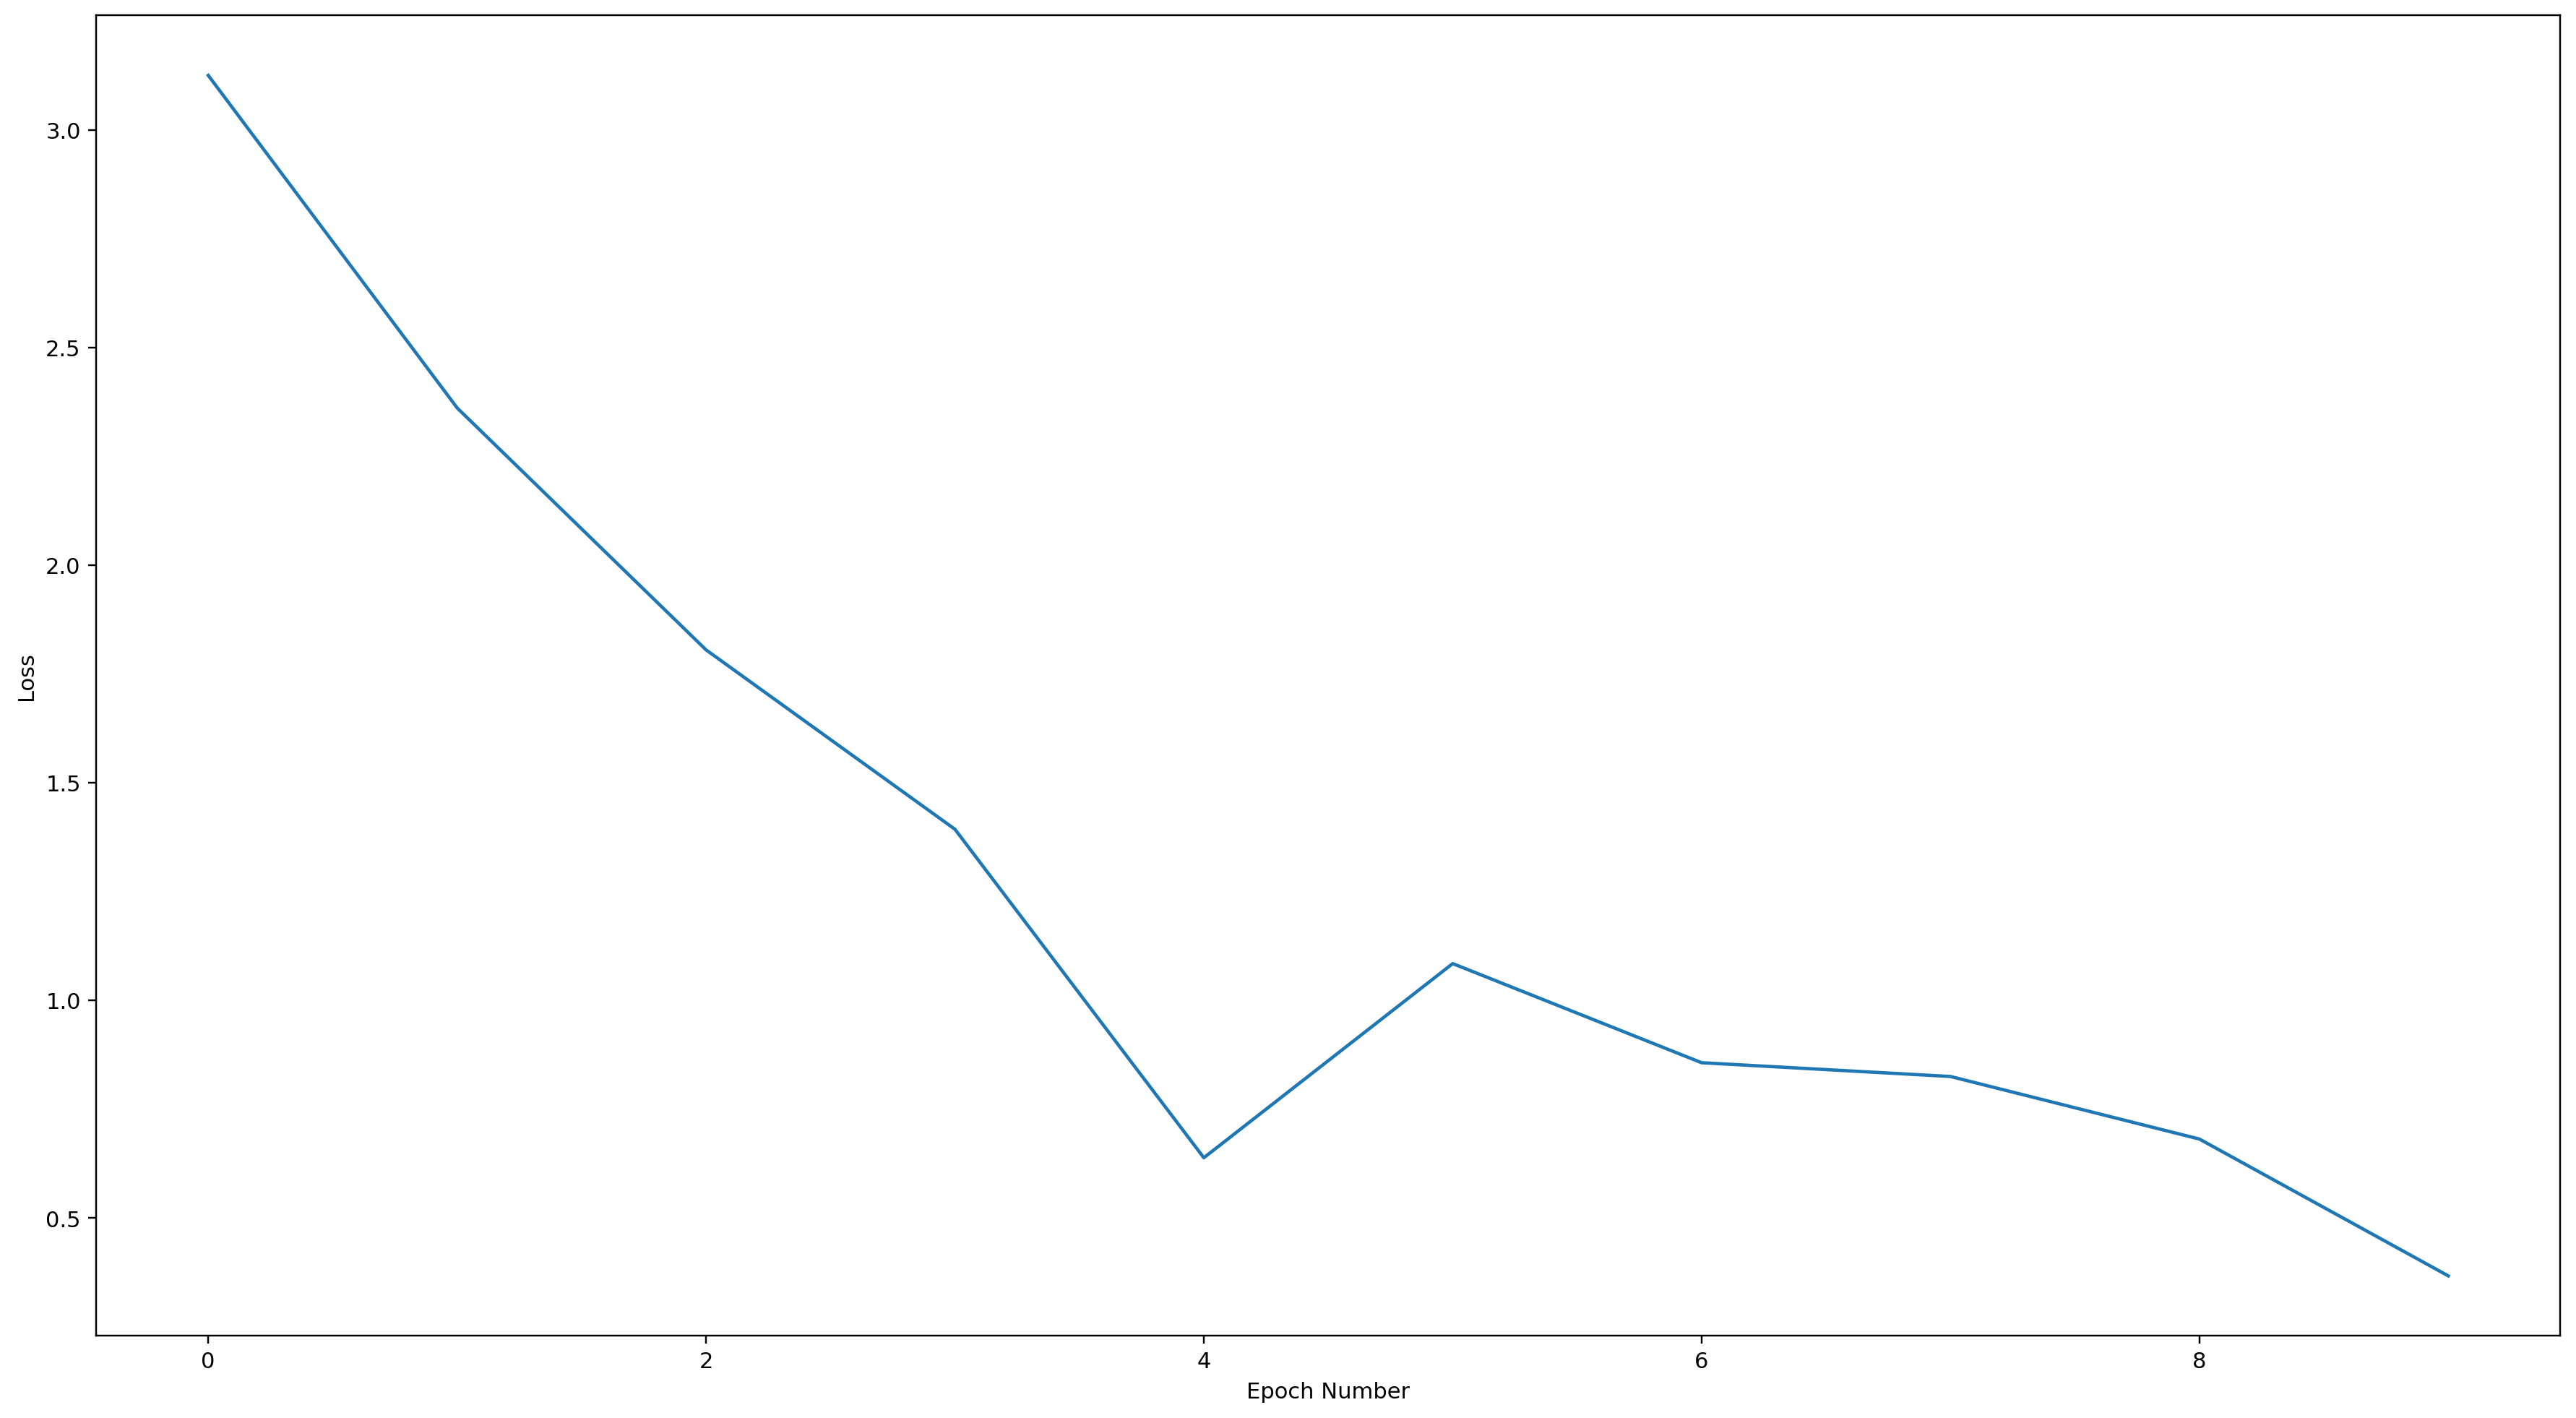

In [6]:
t_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):  
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0],3,64,36))
        labels = labels.to(device).to(torch.long)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
    print("loss",epoch,"=====",float(loss))    
    t_loss.append(float(loss))

    
figure(figsize=(20, 11), dpi=220)    
plt.plot(t_loss)
plt.xlabel("Epoch Number")
plt.ylabel("Loss")


/Users/mohamad/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on the 10000 test images: 2.7777777777777777 %
tensor(51352.4253, dtype=torch.float64)
error =  tensor(96.9915, dtype=torch.float64) %
MAE  1.1847222222222222


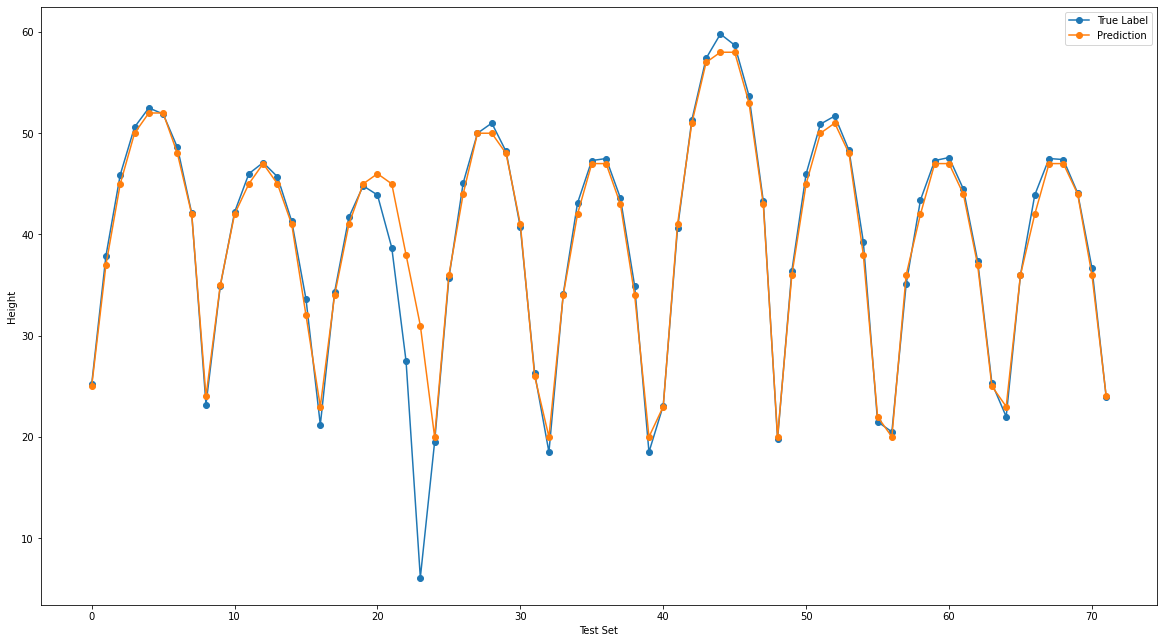

In [8]:
# Test the model
pred = []
pred = torch.tensor(pred)
targets = []
targets = torch.tensor(targets)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        images = torch.reshape(images,(images.shape[0],3,64,36))
        labels = labels.to(device)
        targets = torch.cat((targets,labels),0)
#         print(labels)
        
        outputs = model(images)
#         print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        pred = torch.cat((pred,predicted),0)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 

figure(figsize=(20, 11))
plt.plot(targets,marker='o')
plt.plot(pred,marker='o')
plt.xlabel("Test Set")
plt.ylabel("Height")
plt.legend(["True Label","Prediction"])
print(cost(targets,pred))
MAE_svr = mean_absolute_error(targets,pred)
err_percent = (MAE_svr/targets.mean())*100
print('error = ',100-err_percent,'%' )
print("MAE " ,MAE_svr )